# Libraries

In [1]:
import os
os.chdir('/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src')  # Provide the new path here

In [2]:
from operator import itemgetter
from tqdm import tqdm
import time
from datetime import datetime
import json

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray
import rioxarray
import fiona

#import matplotlib
import matplotlib.pyplot as plt

#from rasterio.enums import Resampling

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler
from torch.utils.data.sampler import RandomSampler
import torch.nn as nn
from torch.autograd import Variable

import wandb

import torchview
from torchview import draw_graph

In [3]:
from models.load_models_1d import *
from dataloaders.load_1d_meteo_wtd import ContinuousDataset
from subprocess import Popen

# Load dictionary

In [4]:
json_file = "/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/configs/continuous_1D_wtd/test_1D.json"
dict_files = {}
with open(json_file) as f:
    dict_files = json.load(f)
    print(f"Read data.json: {dict_files}")

Read data.json: {'experiment_name': 'pizeo_head_1D', 'run_name': 'att_light', 'wandb_dir': '/leonardo_scratch/fast/IscrC_DL4EO/results/continuous_1d/logs', 'save_model_dir': '/leonardo_scratch/fast/IscrC_DL4EO/results/continuous_1d/models', 'data_dir': '/leonardo_work/IscrC_DL4EO/trials/data/', 'wtd_csv_path': '/leonardo_work/IscrC_DL4EO/trials/data/dataset_wtd_roi.csv', 'weather_nc_path': '/leonardo_work/IscrC_DL4EO/trials/data/meteo_bucket_model_snowpack_ROI_1958_2023.nc', 'wtd_shp': '/leonardo_work/IscrC_DL4EO/trials/data/shapefile/underground_wtd_sensor_roi.shp', 'piedmont_shp': '/leonardo_work/IscrC_DL4EO/trials/data/shapefile/piemonte_admin_boundaries.shp', 'dtm_nc': '/leonardo_work/IscrC_DL4EO/trials/data/dtm_ROI.nc', 'weather_dtm': '/leonardo_work/IscrC_DL4EO/trials/data/dtm_ROI_arpa_weather.nc', 'gpu_idx': 2, 'test_split_p': '2018-01-01', 'all_dataset': True, 'max_ds_elems': 100000, 'normalization': True, 'date_max_norm': '2018-01-01', 'fill_value': 0, 'transform': None, 'piez

# Dataset class

In [5]:
ds = ContinuousDataset(dict_files)

Norm factors:
{'target_mean': np.float64(298.52083317743796), 'target_std': np.float64(74.0756468500793), 'dtm_mean': <xarray.DataArray '__xarray_dataarray_variable__' ()> Size: 4B
array(1139.4907, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0, 'dtm_std': <xarray.DataArray '__xarray_dataarray_variable__' ()> Size: 4B
array(884.7991, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0, 'lat_mean': np.float64(44.81300000000007), 'lat_std': np.float64(0.3227486121839514), 'lon_mean': np.float64(7.37549999999999), 'lon_std': np.float64(0.43150656619183275), 'weather_mean': <xarray.Dataset> Size: 64B
Dimensions:      ()
Coordinates:
    spatial_ref  int64 8B 0
Data variables:
    prec         float32 4B 2.601
    tmax         float32 4B 12.35
    tmin         float32 4B 5.036
    tmean        float32 4B 8.692
    prain        float32 4B 2.052
    psnow        float32 4B 0.5488
    et_0         float64 8B 4.873
    r_a          float64 8B 26.37
    snowpack     float64 8B 16.33

In [6]:
print(f"Length of the dataset: {ds.__len__()}")

Length of the dataset: 254820


In [7]:
ds.wtd_df

wtd       lon       lat    height  nan_mask  \
date       sensor_id                                                        
2001-01-01 00405910001   1.800000  0.613639 -0.353667 -0.965821      True   
           00408910001   3.981667  0.813198 -0.759672 -0.886174      True   
           00407810001  39.876667  0.374769 -1.221921 -0.702913      True   
           00105910001        NaN  0.807151  0.148287 -1.018794     False   
           00112710001        NaN  0.689774  0.464772 -1.034881     False   
...                           ...       ...       ...       ...       ...   
2023-12-31 00105110001   3.553333  0.517267  0.444808 -1.021212      True   
           00404110001        NaN  0.833452 -0.080484 -0.998107     False   
           00121510001  14.500000  1.203523  0.596678 -0.974594      True   
           00104810001   2.056667  0.915711  0.472337 -1.014218      True   
           00127210005        NaN  0.667861  0.655431 -1.026275     False   

                               h  
date       sensor_id              
2001-01-01 00405910001 -0.207732  
           00408910001  0.714166  
           00407810001  2.418561  
           00105910001       NaN  
           00112710001       NaN  
...                          ...  
2023-12-31 00105110001 -0.893013  
           00404110001       NaN  
           00121510001 -0.483960  
           00104810001 -0.789269  
           00127210005       NaN  

[260400 rows x 6 columns]

In [8]:
target_t0 = ds.wtd_df[[ds.target, "nan_mask", "lat", "lon", "height"]].loc[ds.wtd_df.index.get_level_values(0) == np.datetime64("2020-01-01")]
target_t0_values = target_t0[ds.target].values
target_t0_mask = target_t0["nan_mask"].values
target_t0_lat = target_t0["lat"].values
target_t0_lon = target_t0["lon"].values
target_t0_dtm = target_t0["height"].values

In [9]:
target_t0["height"].isnull().sum()

np.int64(0)

# Model 

In [10]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [11]:
if dict_files["model"] == "Continuous1DNN_idw":
    print("model idw")
    model = Continuous1DNN_idw(timestep = dict_files["timesteps"],
                 cb_fc_layer = dict_files["cb_fc_layer"],
                 cb_fc_neurons = dict_files["cb_fc_neurons"],
                 conv_filters = dict_files["conv_filters"],
                 lstm_layer = dict_files["lstm_layer"],
                 lstm_input_units = dict_files["lstm_input_units"],
                 lstm_units = dict_files["lstm_units"]
                 ).to(device)

elif dict_files["model"] == "Continuous1DNN_att":
    print("model att")
    model = Continuous1DNN_att(timestep = dict_files["timesteps"],
                 cb_emb_dim = dict_files["cb_emb_dim"],
                 cb_att_h = dict_files["cb_att_h"],
                 cb_fc_layer = dict_files["cb_fc_layer"],
                 cb_fc_neurons = dict_files["cb_fc_neurons"],
                 conv_filters = dict_files["conv_filters"],
                 lstm_layer = dict_files["lstm_layer"],
                 lstm_input_units = dict_files["lstm_input_units"],
                 lstm_units = dict_files["lstm_units"]
                 ).to(device)


model att


In [12]:
print("Total number of trainable parameters: " ,sum(p.numel() for p in model.parameters() if p.requires_grad))

Total number of trainable parameters:  155705


In [12]:
x= ds[2000][0][None,:,:].expand(5 , -1, -1)
z = ds[2000][1][None, :].expand(5, -1)
x_mask = ds[2000][4][None, :].expand(5, -1)

target_dist = torch.cdist(x[:,:,:3], z.unsqueeze(1), p=2.0)
prova = model.idw(dist = target_dist,
                          values = x[:,:,-1].unsqueeze(-1),
                          x_mask = x_mask.unsqueeze(-1),)

In [13]:
prova[1].shape

torch.Size([5])

In [14]:
weather_coords = ds.get_weather_coords()
weather_dtm = ds.get_weather_dtm()
weather_coords = torch.cat([weather_coords, weather_dtm], dim = -1)
weather_coords_batch = weather_coords.unsqueeze(0).expand(1, -1, -1, -1)
w = [ds[2000][2].unsqueeze(0).expand(1, -1, -1, -1, -1),
     weather_coords_batch]

model(x = ds[2000][0][None,:,:].expand(1 , -1, -1),
      z = ds[2000][1][None, :].expand(1, -1),
      w = w,
      x_mask = ds[2000][4][None, :].expand(1, -1))

tensor([-0.0077, -0.0185, -0.0270, -0.0296, -0.0289, -0.0296, -0.0285, -0.0328,
        -0.0357, -0.0302, -0.0245, -0.0247, -0.0289, -0.0325, -0.0328, -0.0309,
        -0.0330, -0.0343, -0.0366, -0.0364, -0.0356, -0.0319, -0.0293, -0.0272,
        -0.0338, -0.0355, -0.0346, -0.0339, -0.0322, -0.0346, -0.0363, -0.0327,
        -0.0347, -0.0366, -0.0368, -0.0341, -0.0346, -0.0345, -0.0321, -0.0324,
        -0.0316, -0.0332, -0.0325, -0.0322, -0.0348, -0.0349, -0.0340, -0.0319,
        -0.0340, -0.0342, -0.0335, -0.0301, -0.0311, -0.0284, -0.0268, -0.0246,
        -0.0149, -0.0170, -0.0113, -0.0049, -0.0096, -0.0207, -0.0246, -0.0264,
        -0.0257, -0.0291, -0.0286, -0.0272, -0.0318, -0.0347, -0.0341, -0.0335,
        -0.0278, -0.0306, -0.0306, -0.0310, -0.0290, -0.0237, -0.0259, -0.0306,
        -0.0287, -0.0253, -0.0200, -0.0174, -0.0159, -0.0140, -0.0220, -0.0269,
        -0.0313, -0.0326, -0.0330, -0.0320, -0.0302, -0.0300, -0.0309, -0.0291,
        -0.0285, -0.0291, -0.0289, -0.02

In [15]:
model_att(x = ds[2000][0][None,:,:].expand(1 , -1, -1),
      z = ds[2000][1][None, :].expand(1, -1),
      w = w,
      x_mask = ds[2000][4][None, :].expand(1, -1))

torch.Size([1, 32, 3])
q: torch.Size([1, 16])
k: torch.Size([1, 31, 16])
torch.Size([1, 20])


tensor([0.0734, 0.0699, 0.0694, 0.0702, 0.0705, 0.0706, 0.0708, 0.0709, 0.0710,
        0.0711, 0.0711, 0.0711, 0.0712, 0.0712, 0.0712, 0.0712, 0.0712, 0.0713,
        0.0713, 0.0713, 0.0713, 0.0713, 0.0713, 0.0713, 0.0713, 0.0713, 0.0713,
        0.0713, 0.0713, 0.0713, 0.0713, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714,
        0.0714, 0.0714, 0.0714, 0.0713, 0.0713, 0.0713, 0.0713, 0.0713, 0.0713,
        0.0713, 0.0713, 0.0713, 0.0713, 0.0713, 0.0713, 0.0713, 0.0713, 0.0713,
        0.0713, 0.0713, 0.0713, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714,
        0.0713, 0.0712, 0.0712, 0.0712, 0.0711, 0.0711, 0.0711, 0.0712, 0.0712,
        0.0712, 0.0712, 0.0712, 0.0712, 0.0712, 0.0712, 0.0712, 0.0712, 0.0712,
        0.0712, 0.0712, 0.0711, 0.0711, 0.0711, 0.0711, 0.0711, 0.0711, 0.0711,
        0.0711, 0.0711, 0.0712, 0.0712, 0.0712, 0.0712, 0.0712, 0.0712, 0.0712,
        0.0712, 0.0712, 0.0712, 0.0712, 0.0712, 0.0712, 0.0712, 0.0712, 0.0711,
        0.0711, 0.0711, 0.0711, 0.0711, 

In [16]:
print("Total number of trainable parameters: " ,sum(p.numel() for p in model_att.parameters() if p.requires_grad))

Total number of trainable parameters:  75409


In [12]:
multihead_attn = nn.MultiheadAttention(3, 1, batch_first=True, vdim=1)
attn_output, attn_output_weights = multihead_attn(query = ds[0][1][None, None, :].expand(1, -1, -1), #(N,L,E)
                                                  key = ds[0][0].unsqueeze(0).expand(1, -1, -1)[:,:,:3],
                                                  value = ds[0][0].unsqueeze(0).expand(1, -1, -1)[:,:,-1].unsqueeze(-1),
                                                  key_padding_mask = ~ds[0][4].unsqueeze(0).expand(1, -1), #(N,S)
                                                   ) 

In [13]:
attn_output.shape

torch.Size([1, 1, 3])

In [14]:
attn_output_weights

tensor([[[0.3742, 0.3128, 0.3130, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]],
       grad_fn=<MeanBackward1>)

In [15]:
ds.wtd_df

wtd       lon       lat  nan_mask         h
date       sensor_id                                                     
2001-01-01 00405910001   1.800000  0.613639 -0.353667      True  0.104921
           00408910001   3.981667  0.813198 -0.759672      True  0.082770
           00407810001  39.876667  0.374769 -1.221921      True -1.069790
           00105910001        NaN  0.807151  0.148287     False       NaN
           00112710001        NaN  0.689774  0.464772     False       NaN
...                           ...       ...       ...       ...       ...
2023-12-31 00105110001   3.553333  0.517267  0.444808      True -0.064020
           00404110001        NaN  0.833452 -0.080484     False       NaN
           00121510001  14.500000  1.203523  0.596678      True -0.153475
           00104810001   2.056667  0.915711  0.472337      True  0.984746
           00127210005        NaN  0.667861  0.655431     False       NaN

[260400 rows x 5 columns]

In [16]:
attn_output

tensor([[[-0.0250,  0.0998, -0.0657]]], grad_fn=<TransposeBackward0>)

In [17]:
ds[0][0].unsqueeze(0)

tensor([[[-0.3537,  0.6136, -0.9658,  0.1049],
         [-0.7597,  0.8132, -0.8862,  0.0828],
         [-1.2219,  0.3748, -0.7029, -1.0698],
         [ 0.1483,  0.8072, -1.0188,  0.0000],
         [ 0.4648,  0.6898, -1.0349,  0.0000],
         [ 0.2368,  0.2765, -0.9950,  0.0000],
         [-0.1250,  0.7241, -0.9973,  0.0000],
         [-0.9135,  0.3633, -0.7772,  0.0000],
         [ 0.7374,  0.6490, -1.0053,  0.0000],
         [ 0.0522, -0.1553, -0.8669,  0.0000],
         [-0.2535, -0.0835, -0.9128,  0.0000],
         [-0.9437,  0.2649, -0.7349,  0.0000],
         [-0.5176,  0.6418, -0.9299,  0.0000],
         [ 0.3484,  1.0944, -1.0181,  0.0000],
         [-0.3848,  1.0897, -0.9726,  0.0000],
         [-0.7525,  0.4624, -0.8527,  0.0000],
         [ 0.2322,  0.7215, -1.0282,  0.0000],
         [-0.1432,  0.3564, -1.0036,  0.0000],
         [ 0.8703,  0.4616, -0.9582,  0.0000],
         [ 0.8216,  0.7954, -1.0433,  0.0000],
         [ 0.6299,  0.3684, -0.9801,  0.0000],
         [ 0.

In [18]:
ds[0][1][None, None, :]

tensor([[[-0.3537,  0.6136, -0.9658]]])

In [19]:
1/1e-8

100000000.0

In [20]:
nn.functional.scaled_dot_product_attention(query = ds[0][1][None, None, :].expand(1, -1, -1), #(N,L,E)
                                            key = ds[0][0].unsqueeze(0).expand(1, -1, -1)[:,:,:3],
                                            value = ds[0][0].unsqueeze(0).expand(1, -1, -1)[:,:,-1].unsqueeze(-1),
                                            attn_mask=)

SyntaxError: invalid syntax (601152665.py, line 4)

# PDE loss sketch

In [110]:
def masked_mse(y_hat, y, mask):
    # y_hat = y_hat.to(device)
    # y = y.to(device)
    # mask = mask.to(device)
    return torch.sum(((y_hat[mask]-y[mask]))**2.0)  / torch.sum(mask)

In [ ]:
def grad(outputs, inputs):
    """Computes the partial derivative of 
    an output with respect to an input.
    Args:
        outputs: (N, 1) tensor
        inputs: (N, D) tensor
    """
    return torch.autograd.grad(
        outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True # FUNZIONA FORSE SOLO PER OUTPUT SCALARI! FORSE MEGLIO APPROCCIO DI DEFINIRE INPUT CON REQUIREGRAD = TRUE E POI FARE BACKWORD 
    )

def physics_loss(y_hat):
    # compute gradients
    h_dlong = 
    h_dlat = 
    h_d2lon = 
    h_d2lat = 
    h_dt = # first diff
    
    pde_res = 
    loss_pde = torch.sum(pde_res**2)
    #control_points_x_ode = torch.linspace(-100, 100, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    #control_points_y_ode = model(control_points_x_ode)
    ode_est = grad(control_points_y_ode, control_points_x_ode)[0]
    pde = 2*control_points_x_ode - ode_est
    
    return torch.mean(pde**2)

# Training

In [8]:
batch_size = dict_files["batch_size"]
max_epochs = dict_files["epochs"]

test_split_p = dict_files["test_split_p"]
train_split_p = 1 - test_split_p

max_ds_elems = ds.__len__()
if not dict_files["all_dataset"]:
    max_ds_elems = dict_files["max_ds_elems"]

train_idx = int(max_ds_elems*train_split_p)
test_idx = int(max_ds_elems*test_split_p)

print(f"Traing size: {train_idx}, Test size: {test_idx}")

train_idxs, test_idxs = np.arange(train_idx), np.arange(train_idx, train_idx + test_idx)

train_sampler = SequentialSampler(train_idxs)
test_sampler = SequentialSampler(test_idxs)

train_loader = torch.utils.data.DataLoader(dataset=ds,
                                            batch_size=batch_size,
                                            sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(dataset=ds,
                                            batch_size=batch_size,
                                            sampler=test_sampler)

Traing size: 203856, Test size: 50964


In [39]:
def plot_predictions(x, y, y_hat, save_dir = None, title = None):
    fig, ax = plt.subplots()
    fig.suptitle("Loss vs iterations")
    ax.plot(x, y_hat, label = "predicted")
    ax.plot(x, y, label = "true")
    ax.legend()
    
    if title is not None:
        ax.set_title(title)
        
    if save_dir:
        plt.savefig(f"{save_dir}.png", bbox_inches = 'tight') #dpi = 400, transparent = True
    
    return fig

In [10]:
def masked_mse(y_hat, y, mask):
    # y_hat = y_hat.to(device)
    # y = y.to(device)
    # mask = mask.to(device)
    return torch.sum(((y_hat[mask]-y[mask]))**2.0)  / torch.sum(mask)

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [13]:
wandb.init(
    entity="gsartor-unito",
    project=dict_files["experiment_name"],
    dir =dict_files["wandb_dir"],
    config=dict_files,
    mode="offline",
)

# Magic
wandb.watch(model, log_freq=100)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


In [112]:
import random

In [41]:
def cpoint_generation(minX, maxX, minY, maxY, dtm,
                      mode = "even",
                      num_lon_point = 100,
                      num_lat_point = 100):
    
    if mode == "even":
        
        # create one-dimensional arrays for x and y
        x = np.linspace(minX, maxX, num_lon_point)
        y = np.linspace(minY, maxY, num_lat_point)
        # create the mesh based on these arrays
        X, Y = np.meshgrid(x, y)
        coords = np.stack([Y, X], axis = -1)
        
        
    dtm_xy = dtm.sel(x = x, y = y,
                     method = "nearest").values
    
    coords = np.concat([coords, np.moveaxis(dtm_xy, 0, -1)], axis=-1)
    coords = coords.reshape(coords.shape[0]*coords.shape[1], coords.shape[2])
        
    return coords

In [132]:
X.shape

(10, 10)

In [150]:
prova = cpoint_generation(minX = ds.dtm_roi.x.min().values, maxX = ds.dtm_roi.x.max().values,
                                                minY = ds.dtm_roi.y.min().values, maxY = ds.dtm_roi.y.max().values,
                                                dtm = ds.dtm_roi,
                                                num_lon_point = 3,
                                                num_lat_point = 2)

print(prova)
print(prova.shape)

[[44.31083333  6.62666667  0.86661679]
 [44.31083333  7.32791667 -0.48569936]
 [44.31083333  8.02916667 -0.44796762]
 [45.265       6.62666667  2.29029632]
 [45.265       7.32791667  0.46968988]
 [45.265       8.02916667 -1.05911243]]
(6, 3)


In [ ]:
def pde_loss_1d():
    return

In [ ]:
long_cpoint, lat_cpoint = cpoint_generation(ds.dtm_roi.x.min().values, ds.dtm_roi.x.max().values,
                  ds.dtm_roi.y.min().values, ds.dtm_roi.y.max().values,
                  mode = "even")

mem allocated in MB:  0.0
############### Training epoch 0 ###############


  0%|          | 0/250 [00:00<?, ?batch/s]

Epoch 0:   0%|          | 0/250 [00:02<?, ?batch/s]

Train loss: 425.80499267578125


Epoch 0:   0%|          | 1/250 [00:11<35:03,  8.45s/batch]

Train loss: 480.5107116699219


Epoch 0:   0%|          | 1/250 [00:16<1:09:58, 16.86s/batch]


############### Test epoch 0 ###############


Epoch 0:   2%|▏         | 1/63 [00:04<04:44,  4.59s/batch]

Test loss: 425.613525390625


Epoch 0:   2%|▏         | 1/63 [00:09<09:36,  9.29s/batch]


Test loss: 480.4068298339844
############### Training epoch 1 ###############


  0%|          | 0/250 [00:01<?, ?batch/s]


KeyboardInterrupt: 

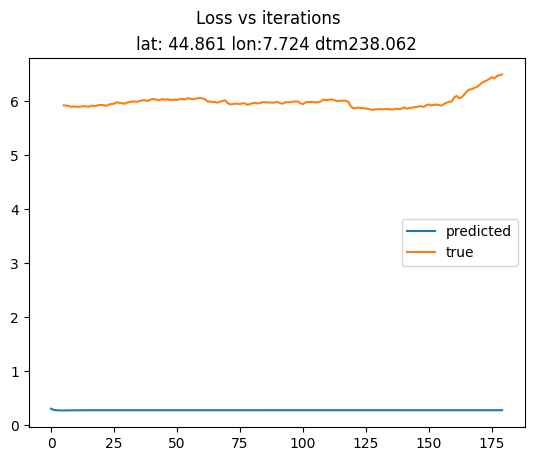

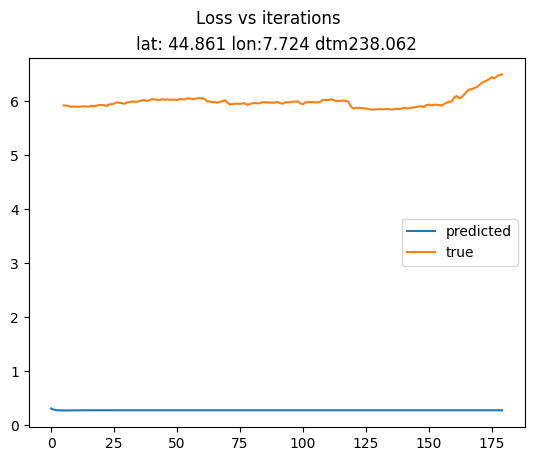

In [17]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

weather_coords = ds.get_weather_coords()
weather_dtm = ds.get_weather_dtm()
weather_coords = torch.cat([weather_coords, weather_dtm], dim = -1)

print('mem allocated in MB: ', torch.cuda.memory_allocated() / 1024**2)
#print(torch.cuda.memory_summary(device=None, abbreviated=False))

for i in range(max_epochs):
    
    model.train(True)
    start_time = time.time()
    print(f"############### Training epoch {i} ###############")
    
    with tqdm(train_loader, unit="batch") as tepoch:
            for batch_idx, (x, z, w_values, y, x_mask, y_mask) in enumerate(tepoch):
                tepoch.set_description(f"Epoch {i}")
                
                x = x.to(device)
                x_mask = x_mask.to(device)
                z = z.to(device)
                weather_coords_batch = weather_coords.unsqueeze(0).expand(w_values.shape[0], -1, -1, -1)
                w = [w_values.to(device), weather_coords_batch.to(device)]
                y = y.to(device)
                y_mask = y_mask.to(device)
                
                optimizer.zero_grad()
                
                y_hat = model(x, z, w, x_mask)
                
                loss_data = masked_mse(y_hat,
                                  y,
                                  y_mask)
                
                print(f"Train data-loss: {loss}")
                
                # Control point generation
                time_cpoint = random.sample(range(x.shape[0]), 10)
                for aug_date_idx in range(len(time_cpoint)):
                    
                    x_cpoint = x[time_cpoint[aug_date_idx],:,:].expand(100,-1,-1)
                    x_mask_cpoint = x_mask[time_cpoint[aug_date_idx],:].expand(100,-1)
                    
                    z_cpoint = cpoint_generation(minX = ds.dtm_roi.x.min().values, maxX = ds.dtm_roi.x.max().values,
                                                minY = ds.dtm_roi.y.min().values, maxY = ds.dtm_roi.y.max().values,
                                                dtm = ds.dtm_roi,
                                                num_lon_point = 10,
                                                num_lat_point = 10)
                    
                    z_cpoint = torch.tensor(z_cpoint).to(device)
                    w_cpoint = w[time_cpoint[aug_date_idx],:,:,:,:].expand(100,-1,-1,-1,-1)
                
                    y_hat_cpoint = model(x_cpoint, z_cpoint, w_cpoint, x_mask_cpoint)
                    y_hat = torch.cat([y_hat, y_hat_cpoint], dim = 0)
                
                loss_pde = pde_loss_1d(y_hat)
                
                loss = loss_data + loss_pde
                    
                loss.backward()
                optimizer.step()
                
                metrics = {
                    "train_loss" : loss
                }
                wandb.log(metrics) 
                
                if batch_idx == 1:
                    break             
                
    end_time = time.time()
    exec_time = end_time-start_time

    wandb.log({"tr_epoch_exec_t" : exec_time})
    # Log the plot
    lat_plot = round(float(z[-1,0].detach().cpu()), 4)
    lon_plot = round(float(z[-1,1].detach().cpu()), 4)
    dtm_plot = round(float(z[-1,2].detach().cpu()))
    wandb.log({"training_pred":wandb.Image(plot_predictions(np.arange(0,dict_files["timesteps"]),
                                                 y[-1,:].detach().cpu(), y_hat[-1,:].detach().cpu(),
                                        title = f"lat: {lat_plot} lon:{lon_plot} dtm:{dtm_plot}"))
               })

    model_name = 'model_{}_{}.pt'.format(timestamp, i)    
    model_dir = dict_files["save_model_dir"]
    torch.save(model.state_dict(), f"{model_dir}/{model_name}") 

    print(f"############### Test epoch {i} ###############")
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()
    start_time = time.time()
    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        with tqdm(test_loader, unit="batch") as tepoch:
                for batch_idx, (x, z, w_values, y, x_mask, y_mask) in enumerate(tepoch):
                    tepoch.set_description(f"Epoch {i}")

                    x = x.to(device)
                    x_mask = x_mask.to(device)
                    z = z.to(device)
                    weather_coords_batch = weather_coords.unsqueeze(0).expand(w_values.shape[0], -1, -1, -1)
                    w = [w_values.to(device), weather_coords_batch.to(device)]
                    y = y.to(device)
                    y_mask = y_mask.to(device)
                    # print('Batch mem allocated in MB: ', torch.cuda.memory_allocated() / 1024**2)

                    y_hat = model(x, z, w, x_mask)
                    # print('After predict mem allocated in MB: ', torch.cuda.memory_allocated() / 1024**2)

                    loss = masked_mse(y_hat,
                                  y,
                                  y_mask)
                    print(f"Test loss: {loss}")

                    metrics = {
                        "test_loss" : loss
                    }

                    wandb.log(metrics)
                    
                    if batch_idx == 1:
                        break  
        
    end_time = time.time()
    exec_time = end_time-start_time
    wandb.log({"test_epoch_exec_t" : exec_time})
    # Log the plot
    lat_plot = round(float(z[-1,0].detach().cpu()), 4)
    lon_plot = round(float(z[-1,1].detach().cpu()), 4)
    dtm_plot = round(float(z[-1,2].detach().cpu()))
    wandb.log({"test_pred": wandb.Image(plot_predictions(np.arange(0,dict_files["timesteps"]), y[-1,:].detach().cpu(), y_hat[-1,:].detach().cpu(),
                                        title = f"lat: {lat_plot} lon:{lon_plot} dtm:{dtm_plot}"))
               })


wandb.finish()

print(f"Execution time: {end_time-start_time}s")

# Physics loss

In [ ]:
# grad function

In [11]:
def physics_loss(model: torch.nn.Module):
    control_points_x_ode = torch.linspace(-100, 100, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    control_points_y_ode = model(control_points_x_ode)
    ode_est = grad(control_points_y_ode, control_points_x_ode)[0]
    pde = 2*control_points_x_ode - ode_est
    
    # Metti temporal encoding in input? 
    pde = 
    pde_res = 
    
    return torch.mean(pde**2)

SyntaxError: invalid syntax (2927248471.py, line 8)

# Test plots

In [ ]:
batch_size = dict_files["batch_size"]
max_epochs = dict_files["epochs"]

max_ds_elems = ds.__len__()
if not dict_files["all_dataset"]:
    max_ds_elems = dict_files["max_ds_elems"]
    
if type(dict_files["test_split_p"]) is str:
    
    train_idx = int(ds.get_iloc_from_date(date_max= np.datetime64(dict_files["test_split_p"])))
    test_idx = int(max_ds_elems - train_idx)
else:
    test_split_p = dict_files["test_split_p"]
    train_split_p = 1 - test_split_p
    
    train_idx = int(max_ds_elems*train_split_p)
    test_idx = int(max_ds_elems*test_split_p)

train_idxs, test_idxs = np.arange(train_idx), np.arange(train_idx,
                                                        train_idx + test_idx)

print(f"Traing size: {train_idx} - {ds.wtd_df.index.get_level_values(0)[train_idxs[-1]]}, Test size: {test_idx} - {ds.wtd_df.index.get_level_values(0)[test_idxs[-1]]}")

# Sampler 
train_sampler = SequentialSampler(train_idxs)
    
test_sampler = SequentialSampler(test_idxs)

train_loader = torch.utils.data.DataLoader(dataset=ds,
                                            batch_size=31,
                                            sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(dataset=ds,
                                            batch_size=31,
                                            sampler=test_sampler)

Traing size: 192478 - 2017-12-31 00:00:00, Test size: 62342 - 2023-07-04 00:00:00


In [ ]:
model_path = "/leonardo_scratch/fast/IscrC_DL4EO/results/continuous_1d/models/model_20250114_151308.pt"
model.load_state_dict(torch.load(model_path, weights_only=True, map_location=torch.device('cpu')))
model.eval()

Continuous1DNN_att(
  (cb_emb): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (multihead_att): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (cb_fc): Sequential(
    (0): Linear(in_features=68, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
  )
  (conv3d_stack): Sequential(
    (0): Conv3d(16, 64, kernel_size=(1, 2, 2), stride=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv3d(64, 64, kernel_size=(1, 2, 2), stride=(1, 1, 1))
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv3d(64, 64, kernel_size=(1, 2, 2), stride=(1, 1, 1))
    (7): BatchNorm3d(64, eps=1e-

In [15]:
def masked_mse(y_hat, y, mask):
    return torch.sum(((y_hat[mask]-y[mask]))**2.0)  / torch.sum(mask)

def masked_mae(y_hat, y, mask):
    return torch.sum(torch.abs((y_hat[mask]-y[mask])))  / torch.sum(mask)

In [16]:
weather_coords = ds.get_weather_coords()
weather_dtm = ds.get_weather_dtm()
weather_coords = torch.cat([weather_coords, weather_dtm], dim = -1)

y_list = []
y_hat_list = []
mse_list = []
mae_list = []

with tqdm(train_loader, unit="batch") as tepoch:
                for batch_idx, (x, z, w_values, y, x_mask, y_mask) in enumerate(tepoch):
                    #tepoch.set_description(f"Epoch {i}")

                    x = x.to(device)
                    x_mask = x_mask.to(device)
                    z = z.to(device)
                    weather_coords_batch = weather_coords.unsqueeze(0).expand(w_values.shape[0], -1, -1, -1)
                    w = [w_values.to(device), weather_coords_batch.to(device)]
                    y = y.to(device)
                    y_mask = y_mask.to(device)
                    
                    y_hat = model(x, z, w, x_mask)
                    # denormalize 
                    y_hat = (y_hat * ds.norm_factors["target_std"]) + ds.norm_factors["target_mean"]
                    y = (y * ds.norm_factors["target_std"]) + ds.norm_factors["target_mean"]
                    
                    y_list.append(y)
                    y_hat_list.append(y_hat)

                    mse = masked_mse(y_hat,
                                  y,
                                  y_mask)
                    mse_list.append(mse)
                    
                    mae = masked_mae(y_hat,
                                  y,
                                  y_mask)
                    mae_list.append(mae)
                    
                    if batch_idx == 5:
                        break

  0%|          | 0/6209 [00:00<?, ?batch/s]

  0%|          | 5/6209 [00:17<6:08:53,  3.57s/batch]


In [17]:
sample_day = 0

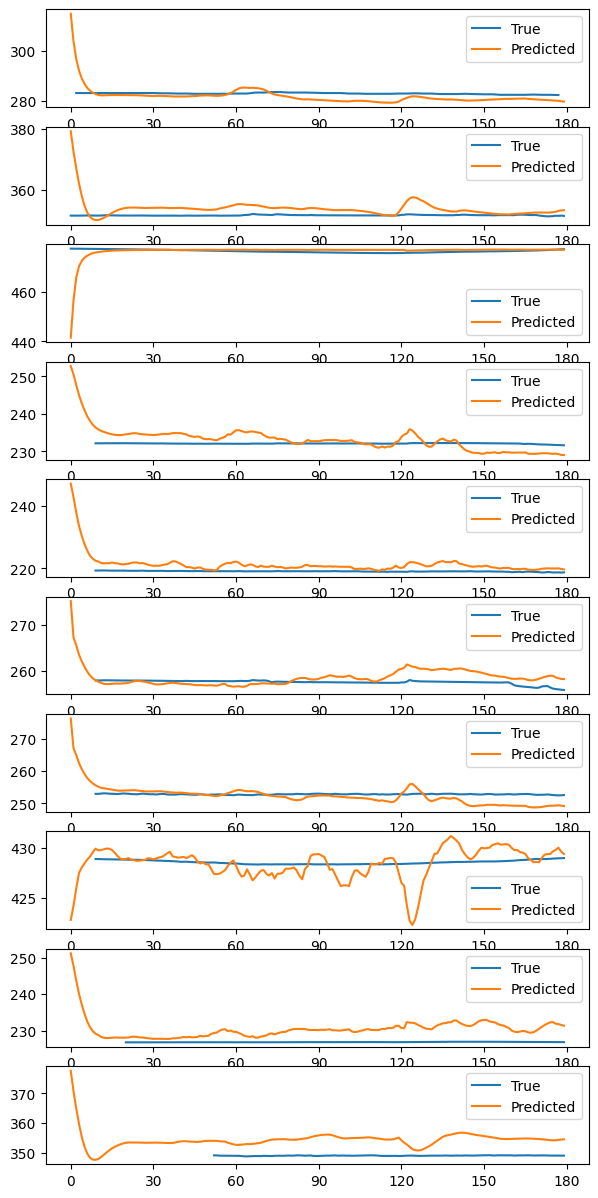

In [18]:
fig, ax = plt.subplots(10, figsize = (7,15))
for i in range(10):
        y = y_list[sample_day][i, :].detach().numpy()
        y_idx = np.argwhere(~np.isnan(y))

        ax[i].plot(y_idx, y[y_idx], label = "True")
        ax[i].plot(np.arange(180), y_hat_list[sample_day][i, :].detach().numpy(), label = "Predicted")
        ax[i].set_xticks(np.arange(181, step = 30) )
        ax[i].legend()
        
plt.show()

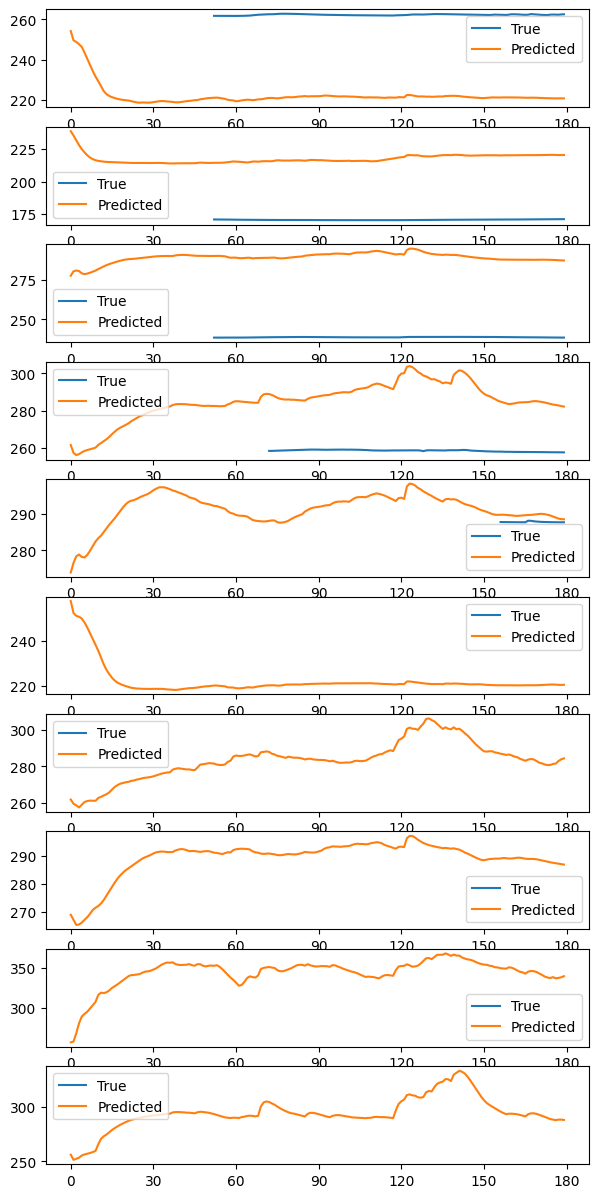

In [18]:
fig, ax = plt.subplots(10, figsize = (7,15))
for i in range(10,20):
        y = y_list[sample_day][i, :].detach().numpy()
        y_idx = np.argwhere(~np.isnan(y))

        ax[i - 10].plot(y_idx, y[y_idx], label = "True")
        ax[i - 10].plot(np.arange(180), y_hat_list[sample_day][i, :].detach().numpy(), label = "Predicted")
        ax[i - 10].set_xticks(np.arange(181, step = 30) )
        ax[i - 10].legend()
        
plt.show()

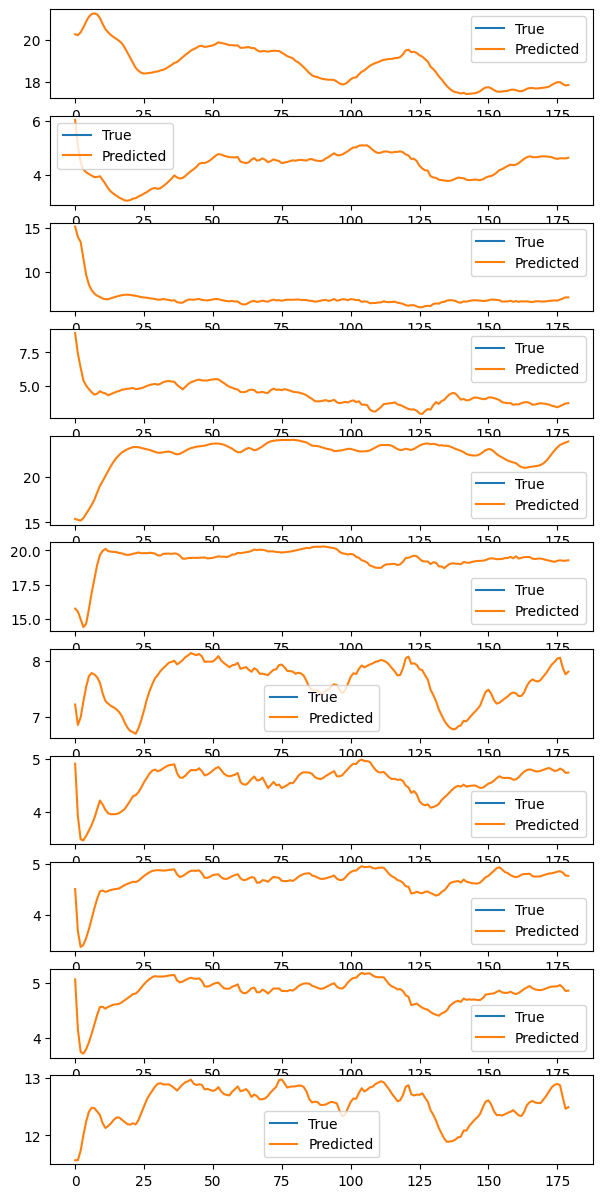

In [22]:
fig, ax = plt.subplots(11, figsize = (7,15))
for i in range(20,31):
        ax[i-20].plot(np.arange(180), y_list[0][(sample_day * 31) + i, :].detach().numpy(), label = "True")
        ax[i-20].plot(np.arange(180), y_hat_list[0][(sample_day * 31) + i, :].detach().numpy(), label = "Predicted")
        ax[i-20].legend()

In [ ]:
MAE = nn.L1Loss()
MSE = nn.MSELoss()

# Compute MAE
output_tensor = MAE(test_prediction, test_target)

# Compute RMSE
RMSE = MSE(test_prediction, test_target)
RMSE = torch.sqrt(RMSE)

print("MAE: ", MAE)
print("RSME: ", RMSE)

# Map predictions

In [15]:
def cpoint_generation(minX, maxX, minY, maxY, dtm,
                      mode = "even",
                      num_lon_point = 100,
                      num_lat_point = 100):
    
    if mode == "even":
        
        # create one-dimensional arrays for x and y
        x = np.linspace(minX, maxX, num_lon_point)
        y = np.linspace(minY, maxY, num_lat_point)[::-1]
        # create the mesh based on these arrays
        X, Y = np.meshgrid(x, y)
        coords = np.stack([Y, X], axis = -1)
        
        
    dtm_xy = dtm.sel(x = x, y = y,
                     method = "nearest").values
    
    coords = np.concat([coords, np.moveaxis(dtm_xy, 0, -1)], axis=-1)
    coords = coords.reshape(coords.shape[0]*coords.shape[1], coords.shape[2])
        
    return coords

In [16]:
sample_date = np.datetime64("2010-06-01")
sample_idx = ds.get_iloc_from_date(date_max = sample_date)

In [17]:
ds.wtd_df.iloc[sample_idx,:]

wtd              NaN
lon         0.667861
lat         0.655431
height     -1.026275
nan_mask       False
h                NaN
Name: (2010-05-31 00:00:00, 00127210005), dtype: object

In [18]:
x = ds[sample_idx][0].unsqueeze(0)
z = ds[sample_idx][1].unsqueeze(0)
x_mask = ds[sample_idx][4].unsqueeze(0)

weather_coords = ds.get_weather_coords()
weather_dtm = ds.get_weather_dtm()
weather_coords = torch.cat([weather_coords, weather_dtm], dim = -1)
weather_coords_batch = weather_coords.unsqueeze(0)

w = [ds[sample_idx][2].unsqueeze(0),
     weather_coords_batch]

In [19]:
lon_point = 30
lat_point = int(lon_point * 0.75)
total_cpoint = lat_point * lon_point
x_cpoint = x.expand(total_cpoint,-1,-1)
x_mask_cpoint = x_mask.expand(total_cpoint,-1)
                    
z_cpoint = cpoint_generation(minX = ds.dtm_roi.x.min().values, maxX = ds.dtm_roi.x.max().values,
                                                minY = ds.dtm_roi.y.min().values, maxY = ds.dtm_roi.y.max().values,
                                                dtm = (ds.dtm_roi *ds.norm_factors["dtm_std"]) + ds.norm_factors["dtm_mean"],
                                                num_lon_point = lon_point,
                                                num_lat_point = lat_point)

# normalization 
z_cpoint[:,0] = (z_cpoint[:,0] - ds.norm_factors["lat_mean"])/ds.norm_factors["lat_std"]
z_cpoint[:,1] = (z_cpoint[:,1] - ds.norm_factors["lon_mean"])/ds.norm_factors["lon_std"]
z_cpoint[:,2] = (z_cpoint[:,2] - ds.norm_factors["dtm_mean"].values)/ds.norm_factors["dtm_std"].values
                    
z_cpoint = torch.tensor(z_cpoint).to(torch.float32).to(device)
w_cpoint = [w[0].expand(total_cpoint,-1,-1,-1,-1),
            w[1].expand(total_cpoint,-1,-1,-1)]
                
y_hat_cpoint = model(x_cpoint, z_cpoint, w_cpoint, x_mask_cpoint)

In [20]:
from rasterio.enums import Resampling

dtm_denorm = (ds.dtm_roi *ds.norm_factors["dtm_std"]) + ds.norm_factors["dtm_mean"]

# downscaling dtm
#downscale_factor = 0.05
new_width = lon_point #int(dtm_roi.rio.width * downscale_factor)
new_height = lat_point #int(dtm_roi.rio.height * downscale_factor)

dtm_denorm_downsampled = dtm_denorm.rio.reproject(
    dtm_denorm.rio.crs,
    shape=(new_height, new_width),
    resampling=Resampling.bilinear,
)

In [25]:
# varia prima long (6.7 in senso crescente)
# poi varia lat (in senso crescente)

# primo elemento (alto sx è quindi) 

In [21]:
z_cpoint[:,0] = (z_cpoint[:,0]*ds.norm_factors["lat_std"]) +  ds.norm_factors["lat_mean"]
z_cpoint[:,1] = (z_cpoint[:,1]*ds.norm_factors["lon_std"]) + ds.norm_factors["lon_mean"]

In [22]:
h_pred = y_hat_cpoint.reshape(lat_point,lon_point,180).detach().numpy()
h_pred = (h_pred* ds.norm_factors["target_std"]) + ds.norm_factors["target_mean"]

sample_h = xarray.DataArray(data = h_pred,
                               coords = dict(
                                        lon=("lon", z_cpoint[:,1].unique().detach().numpy()),
                                        lat=("lat", z_cpoint[:,0].unique().detach().numpy()[::-1]),
                                        time=np.arange(180)),
                               dims = ["lat", "lon", "time"]
                               )

wtd_pred = []
for timestep in range(180):
     wtd_pred.append(dtm_denorm_downsampled.values.squeeze() - sample_h[:,:,timestep].values)

wtd_pred = np.stack(wtd_pred, axis = -1)
sample_wtd = xarray.DataArray(data = wtd_pred,
                               coords = dict(
                                        lon=("lon", z_cpoint[:,1].unique().detach().numpy()),
                                        lat=("lat", z_cpoint[:,0].unique().detach().numpy()[::-1]),
                                        time=np.arange(180)),
                               dims = ["lat", "lon", "time"]
                               )

In [23]:
sample_wtd.min()

<xarray.DataArray ()> Size: 8B
array(-67.87925113)

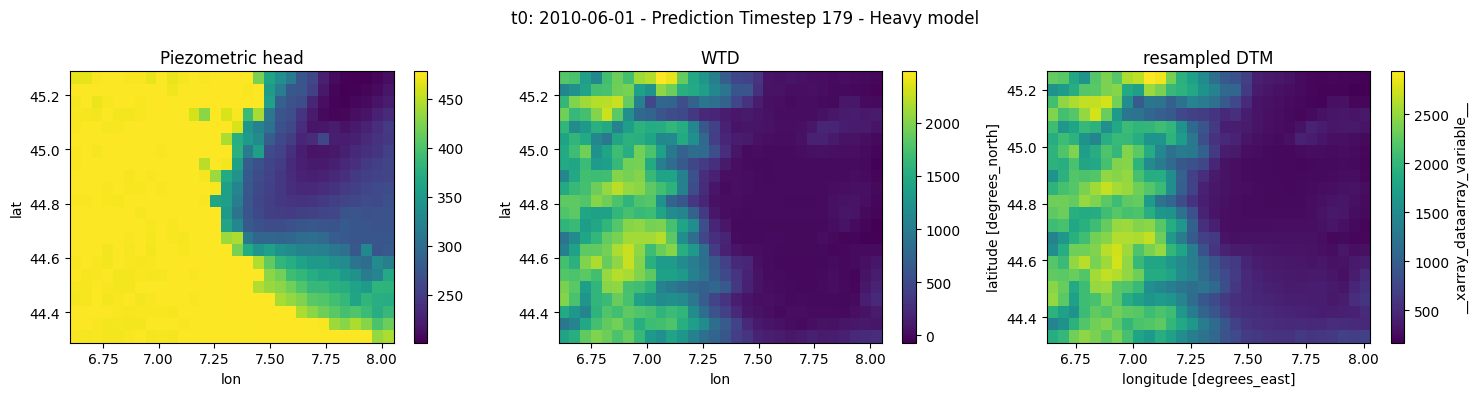

In [29]:
pred_timestep = 179
fig, ax = plt.subplots(1,3, figsize = (15,4))
fig.suptitle(f"t0: {sample_date} - Prediction Timestep {pred_timestep} - Heavy model")

sample_h[:,:,pred_timestep].plot(ax = ax[0])
ax[0].set_title("Piezometric head")


sample_wtd[:,:,pred_timestep].plot(ax = ax[1], vmin = sample_wtd.min().values,
                        vmax = sample_wtd.max().values)
ax[1].set_title("WTD")


dtm_denorm_downsampled.plot(ax = ax[2])
ax[2].set_title("resampled DTM")

plt.tight_layout()

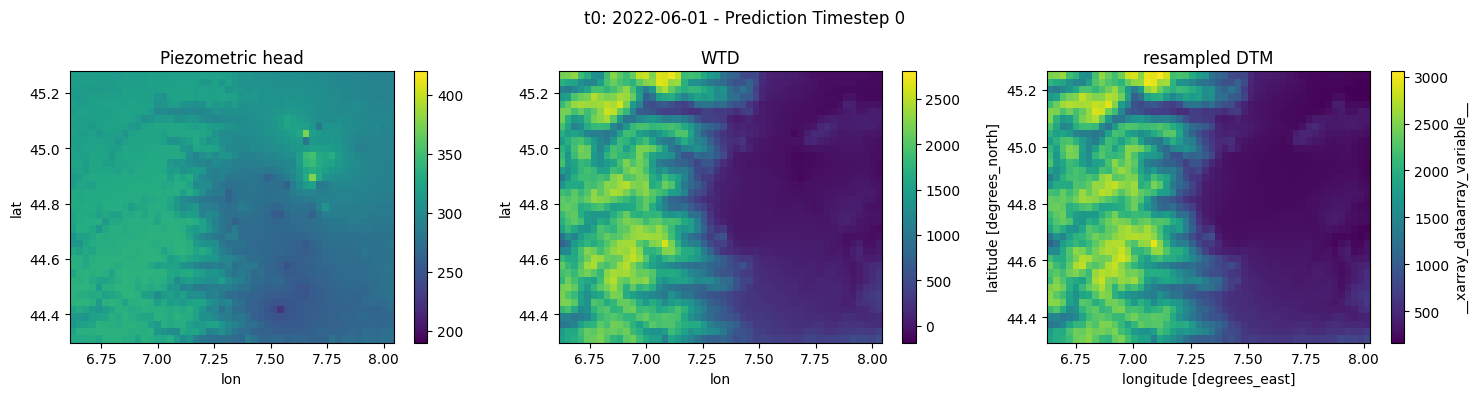

In [45]:
pred_timestep = 0
fig, ax = plt.subplots(1,3, figsize = (15,4))
fig.suptitle(f"t0: {sample_date} - Prediction Timestep {pred_timestep}")

sample_h[:,:,pred_timestep].plot(ax = ax[0], vmin = 190, vmax = 420)
ax[0].set_title("Piezometric head")


sample_wtd[:,:,pred_timestep].plot(ax = ax[1], vmin = sample_wtd.min().values,
                        vmax = sample_wtd.max().values)
ax[1].set_title("WTD")


dtm_denorm_downsampled.plot(ax = ax[2])
ax[2].set_title("resampled DTM")

plt.tight_layout()

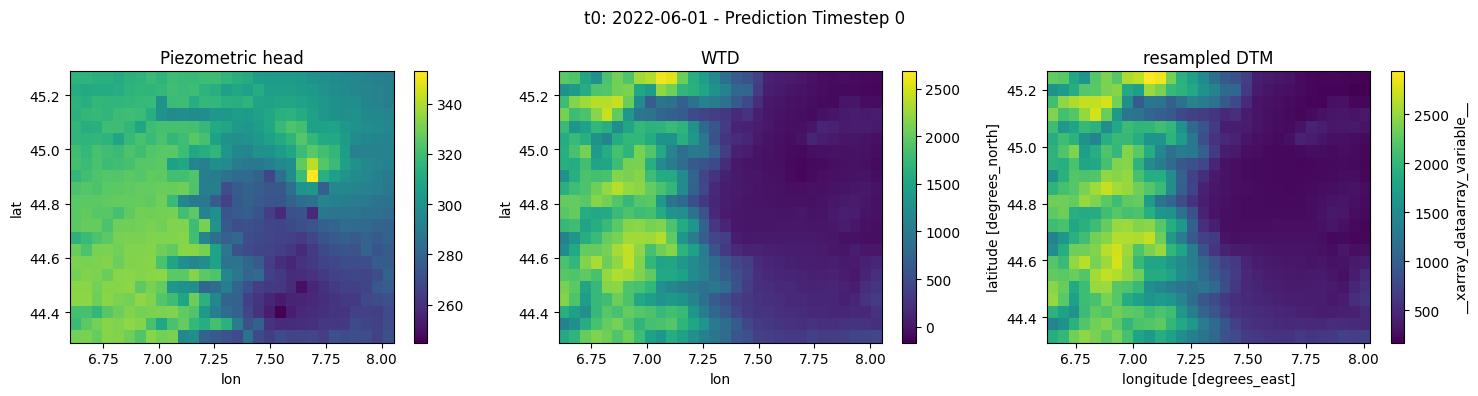

In [27]:
pred_timestep = 0
fig, ax = plt.subplots(1,3, figsize = (15,4))
fig.suptitle(f"t0: {sample_date} - Prediction Timestep {pred_timestep}")

sample_h[:,:,pred_timestep].plot(ax = ax[0])
ax[0].set_title("Piezometric head")


sample_wtd[:,:,pred_timestep].plot(ax = ax[1], vmin = sample_wtd.min().values,
                        vmax = sample_wtd.max().values)
ax[1].set_title("WTD")


dtm_denorm_downsampled.plot(ax = ax[2])
ax[2].set_title("resampled DTM")

plt.tight_layout()

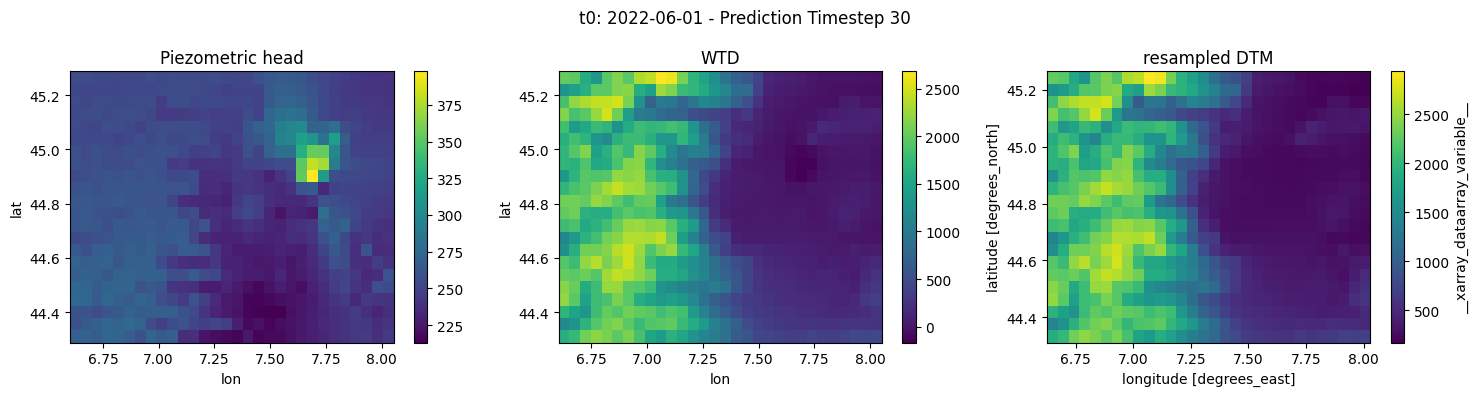

In [28]:
pred_timestep = 30
fig, ax = plt.subplots(1,3, figsize = (15,4))
fig.suptitle(f"t0: {sample_date} - Prediction Timestep {pred_timestep}")

sample_h[:,:,pred_timestep].plot(ax = ax[0])
ax[0].set_title("Piezometric head")


sample_wtd[:,:,pred_timestep].plot(ax = ax[1], vmin = sample_wtd.min().values,
                        vmax = sample_wtd.max().values)
ax[1].set_title("WTD")


dtm_denorm_downsampled.plot(ax = ax[2])
ax[2].set_title("resampled DTM")
plt.tight_layout()

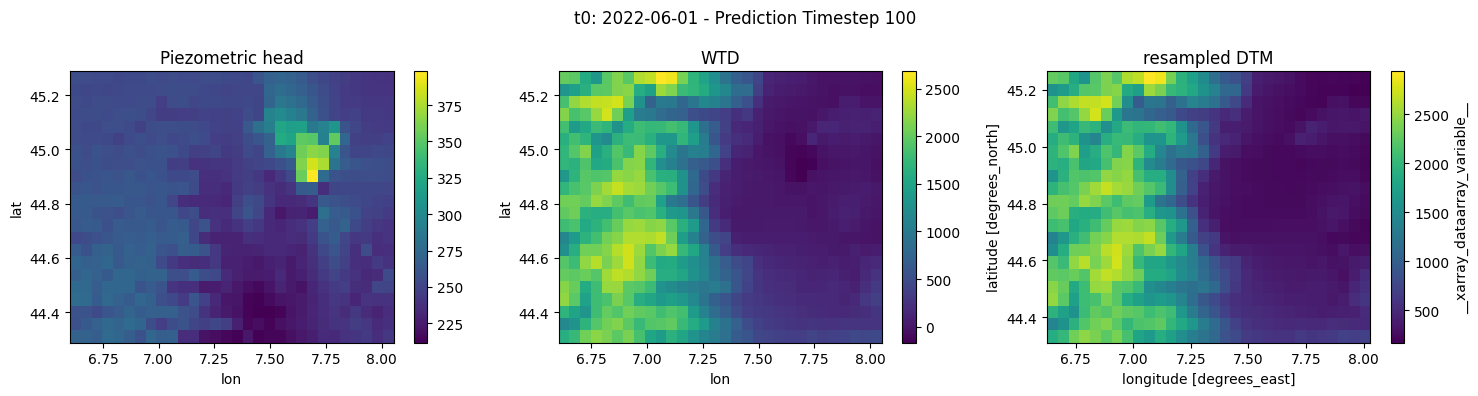

In [29]:
pred_timestep = 100
fig, ax = plt.subplots(1,3, figsize = (15,4))
fig.suptitle(f"t0: {sample_date} - Prediction Timestep {pred_timestep}")

sample_h[:,:,pred_timestep].plot(ax = ax[0])
ax[0].set_title("Piezometric head")


sample_wtd[:,:,pred_timestep].plot(ax = ax[1], vmin = sample_wtd.min().values,
                        vmax = sample_wtd.max().values)
ax[1].set_title("WTD")


dtm_denorm_downsampled.plot(ax = ax[2])
ax[2].set_title("resampled DTM")
plt.tight_layout()

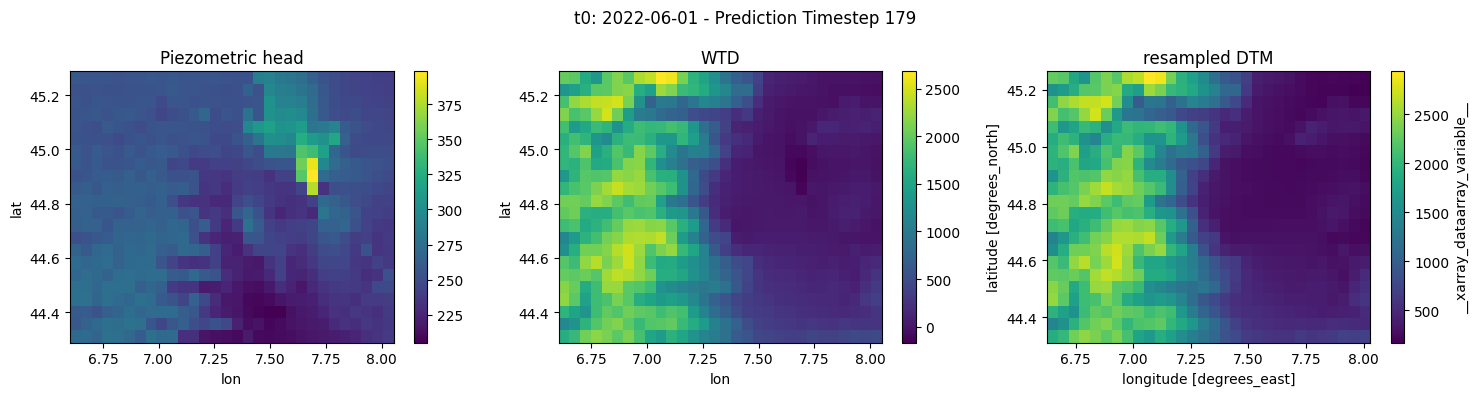

In [30]:
pred_timestep = 179
fig, ax = plt.subplots(1,3, figsize = (15,4))
fig.suptitle(f"t0: {sample_date} - Prediction Timestep {pred_timestep}")

sample_h[:,:,pred_timestep].plot(ax = ax[0])
ax[0].set_title("Piezometric head")


sample_wtd[:,:,pred_timestep].plot(ax = ax[1], vmin = sample_wtd.min().values,
                        vmax = sample_wtd.max().values)
ax[1].set_title("WTD")


dtm_denorm_downsampled.plot(ax = ax[2])
ax[2].set_title("resampled DTM")
plt.tight_layout()

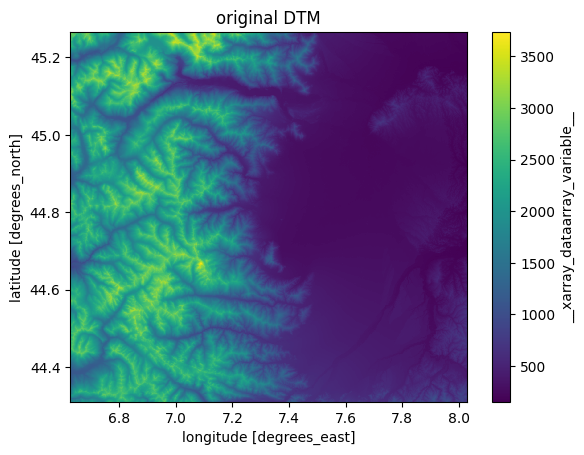

In [166]:
dtm_denorm.plot()
plt.title("original DTM")
plt.show()

In [141]:
sample_pred = sample_h.to_dataset(name = "h")

In [143]:
sample_pred = sample_pred.assign(wtd = sample_wtd)

In [169]:
sample_pred

<xarray.Dataset> Size: 866kB
Dimensions:  (lon: 20, lat: 15, time: 180)
Coordinates:
  * lon      (lon) float32 80B 6.627 6.7 6.774 6.848 ... 7.808 7.882 7.955 8.029
  * lat      (lat) float32 60B 44.31 44.38 44.45 44.52 ... 45.13 45.2 45.26
  * time     (time) int64 1kB 0 1 2 3 4 5 6 7 ... 173 174 175 176 177 178 179
Data variables:
    h        (lat, lon, time) float64 432kB 333.8 326.9 319.0 ... 256.6 256.4
    wtd      (lat, lon, time) float64 432kB -1.678e+03 -1.685e+03 ... -369.1